Yolov3 Demo

In [1]:
import torch
from sagemakercv.detection.detector import build_detection_model
from utils1 import (unarchive_data, 
                   get_training_world, 
                   is_sm, 
                   is_sm_dist, 
                   get_herring_world,
                   config_check)
from sagemakercv.training import make_optimizer, make_lr_scheduler
from sagemakercv.data import make_data_loader
from sagemakercv.data.utils import prefetcher
from sagemakercv.utils.checkpoint import DetectronCheckpointer
from sagemakercv.utils.runner import build_hooks, Runner
from sagemakercv.utils.runner.hooks.checkpoint import DetectronCheckpointHook
from sagemakercv.training.trainers import train_step
import apex
from configs import cfg
from tqdm.auto import tqdm
from statistics import mean

if (torch._C, '_jit_set_profiling_executor') :
    torch._C._jit_set_profiling_executor(False)
if (torch._C, '_jit_set_profiling_mode') :
    torch._C._jit_set_profiling_mode(False)
    

In [2]:
cfg.merge_from_file('configs/st_yolo_bs8.yaml')

In [3]:
#config_check(cfg)
# cfg.freeze()

Load dataset - COCO

In [4]:
train_coco_loader, num_iterations = make_data_loader(cfg)

loading annotations into memory...
Done (t=15.48s)
creating index...
index created!


In [5]:
device = torch.device(cfg.MODEL.DEVICE)
train_iterator = prefetcher(iter(train_coco_loader), device)

[2021-08-04 07:53:18.834 smcv-pt-1-8-ml-p3-8xlarge-4e632c7d8fc57b8535f1324c7fed:10344 INFO utils.py:27] RULE_JOB_STOP_SIGNAL_FILENAME: None
[2021-08-04 07:53:18.877 smcv-pt-1-8-ml-p3-8xlarge-4e632c7d8fc57b8535f1324c7fed:10344 INFO profiler_config_parser.py:102] Unable to find config at /opt/ml/input/config/profilerconfig.json. Profiler is disabled.


Build model
Backbone: Darknet 53
Neck: Yolov3

In [6]:
from sagemakercv.detection.backbone.darknet import build_darknet_backbone
backbone = build_darknet_backbone(cfg)
# load weights
backbone_weights_path = '/home/sagemaker-user/data/weights/yolov3.weights'
backbone.load_darknet_weights(backbone_weights_path)

total len weights =  (62001757,)


In [7]:
from sagemakercv.detection.dense_heads.yolo_head import build_yolo_head
model = build_yolo_head(cfg)

Load weights and Training

In [8]:
# backbone_weights = torch.load('/home/sagemaker-user/data/weights/epoch_60.ph')
# backbone_weights = {i.replace('module.', ''):j for i,j in backbone_weights.items() if not i.startswith('module.fc.')}

# freeze different layers
# backbone_weights = torch.load('/home/sagemaker-user/data/weights/yolov3.weights')
# backbone_weights = {i.replace('module.', ''):j for i,j in backbone_weights.items() if not i.startswith('module.fc.')}
# model_train.backbone.backbone.load_state_dict(backbone_weights)

In [9]:
from sagemakercv.detection.detector.yolo_detector import yolov3_model
model_train = yolov3_model(backbone, model, cfg)

In [10]:
from apex.parallel import DistributedDataParallel as DDP
from apex import amp

#set device
torch.cuda.set_device(0)
# torch.cuda.set_device(1)
print(torch.cuda.current_device())
device = torch.device(cfg.MODEL.DEVICE)

#batch size
cfg.SOLVER.IMS_PER_BATCH = 8
# revise learning rate
cfg.SOLVER.BASE_LR = 0.005 # max lr or base lr init_lr
# change lr by batch size
# lr = 0.001;
# policy=steps
# steps=400000,450000
# scales=.1,.1


# certain layers to freeze
# freeze everything in the backbone OR freeze everything but the last three layers
last_three = [] # use this to freeze everything
last_three = ['residual_block3.3', 
              'residual_block4.3', 
              'residual_block5.3']

for name, param in model_train.backbone.backbone.named_parameters():
    param.requires_grad = False
    for l in last_three:
        if l in name:
            param.requires_grad = True
        
#set optimizer, revise learning rate
model_train = model_train.to(device)
optimizer = torch.optim.SGD(model_train.parameters(), lr = cfg.SOLVER.BASE_LR,
                              weight_decay=4e-05,)
scheduler = make_lr_scheduler(cfg, optimizer)
losses, parsed_targets, pred_maps = model_train(*next(train_iterator))
model_train, optimizer = amp.initialize(model_train, optimizer, 
                                      opt_level='O1')
# model_train = DDP(model_train)


        
#revise loss function (now: add everything up)
def train_step(images, targets, model, optimizer, scheduler, device, grad_clip=0.0):
    optimizer.zero_grad()
    losses, parsed_targets, pred_maps = model(images, targets)
    
    # use mixed percision
    # losses['weighted_total_loss'].backward()
    with apex.amp.scale_loss(losses['weighted_total_loss'], optimizer) as scaled_loss:
            scaled_loss.backward()
            
            
    if grad_clip>0.0:
        torch.nn.utils.clip_grad_norm_(model.parameters(), grad_clip)
    optimizer.step()
    scheduler.step()
    return losses

def train_epoch(data_iterator, steps, log=True, log_interval=50):
    # add apex
    model_train.train()
    
    for i in range(steps):
        images, targets = next(data_iterator)
        loss_dict = train_step(images, targets, model_train, optimizer, scheduler, device)
        if log and i%log_interval==0:
            print(f"Step {i}, Loss: {float(loss_dict['weighted_total_loss'])}, LR: {scheduler.get_lr()[0]}")
            print(f"Step {i}, Objective loss: {float(loss_dict['obj_loss'])}, Class loss: {float(loss_dict['class_loss'])}, xy loss: {float(loss_dict['xy_loss'])}, wh loss: {float(loss_dict['wh_loss'])}")

0
Selected optimization level O1:  Insert automatic casts around Pytorch functions and Tensor methods.

Defaults for this optimization level are:
enabled                : True
opt_level              : O1
cast_model_type        : None
patch_torch_functions  : True
keep_batchnorm_fp32    : None
master_weights         : None
loss_scale             : dynamic
Processing user overrides (additional kwargs that are not None)...
After processing overrides, optimization options are:
enabled                : True
opt_level              : O1
cast_model_type        : None
patch_torch_functions  : True
keep_batchnorm_fp32    : None
master_weights         : None
loss_scale             : dynamic


In [11]:
train_epoch(train_iterator, 50000)
# training with freezed layers
# scaled losses

Step 0, Loss: 13.466508865356445, LR: 0.00014273400000000002
Step 0, Objective loss: 0.7202640175819397, Class loss: 4.364995956420898, xy loss: 3.732840061187744, wh loss: 3.2089524269104004
Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 32768.0
Step 50, Loss: 13.08971118927002, LR: 0.000629434
Step 50, Objective loss: 0.7085050344467163, Class loss: 4.319311141967773, xy loss: 2.9996399879455566, wh loss: 3.1661548614501953
Step 100, Loss: 13.961822509765625, LR: 0.001116134
Step 100, Objective loss: 0.6788467168807983, Class loss: 4.191110610961914, xy loss: 4.765613555908203, wh loss: 5.007676124572754
Step 150, Loss: 12.062283515930176, LR: 0.001602834
Step 150, Objective loss: 0.6455047130584717, Class loss: 3.6928906440734863, xy loss: 3.9543681144714355, wh loss: 3.8902993202209473
Step 200, Loss: 13.065711975097656, LR: 0.0020895339999999997
Step 200, Objective loss: 0.5768230557441711, Class loss: 3.8040952682495117, xy loss: 4.052078723907471, wh los

In [18]:
import math
import time
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
import numpy as np


def bbox_iou(box1, box2, x1y1x2y2=True):
    """
    Returns the IoU of two bounding boxes
    """
    if not x1y1x2y2:
        # Transform from center and width to exact coordinates
        b1_x1, b1_x2 = box1[:, 0] - box1[:, 2] / 2, box1[:, 0] + box1[:, 2] / 2
        b1_y1, b1_y2 = box1[:, 1] - box1[:, 3] / 2, box1[:, 1] + box1[:, 3] / 2
        b2_x1, b2_x2 = box2[:, 0] - box2[:, 2] / 2, box2[:, 0] + box2[:, 2] / 2
        b2_y1, b2_y2 = box2[:, 1] - box2[:, 3] / 2, box2[:, 1] + box2[:, 3] / 2
    else:
        # Get the coordinates of bounding boxes
        b1_x1, b1_y1, b1_x2, b1_y2 = box1[:,0], box1[:,1], box1[:,2], box1[:,3]
        b2_x1, b2_y1, b2_x2, b2_y2 = box2[:,0], box2[:,1], box2[:,2], box2[:,3]

    # get the corrdinates of the intersection rectangle
    inter_rect_x1 =  torch.max(b1_x1, b2_x1)
    inter_rect_y1 =  torch.max(b1_y1, b2_y1)
    inter_rect_x2 =  torch.min(b1_x2, b2_x2)
    inter_rect_y2 =  torch.min(b1_y2, b2_y2)
    # Intersection area
    inter_area =    torch.clamp(inter_rect_x2 - inter_rect_x1 + 1, min=0) * \
                    torch.clamp(inter_rect_y2 - inter_rect_y1 + 1, min=0)
    # Union Area
    b1_area = (b1_x2 - b1_x1 + 1) * (b1_y2 - b1_y1 + 1)
    b2_area = (b2_x2 - b2_x1 + 1) * (b2_y2 - b2_y1 + 1)

    iou = inter_area / (b1_area + b2_area - inter_area + 1e-16)

    return iou

def non_max_suppression(prediction, num_classes, conf_thres=0.5, nms_thres=0.4):
    """
    Removes detections with lower object confidence score than 'conf_thres' and performs
    Non-Maximum Suppression to further filter detections.
    Returns detections with shape:
        (x1, y1, x2, y2, object_conf, class_score, class_pred)
    """

    # From (center x, center y, width, height) to (x1, y1, x2, y2)
    box_corner = prediction.new(prediction.shape)
    box_corner[:, :, 0] = prediction[:, :, 0] - prediction[:, :, 2] / 2
    box_corner[:, :, 1] = prediction[:, :, 1] - prediction[:, :, 3] / 2
    box_corner[:, :, 2] = prediction[:, :, 0] + prediction[:, :, 2] / 2
    box_corner[:, :, 3] = prediction[:, :, 1] + prediction[:, :, 3] / 2
    prediction[:, :, :4] = box_corner[:, :, :4]

    output = [None for _ in range(len(prediction))]
    for image_i, image_pred in enumerate(prediction):
        # Filter out confidence scores below threshold
        conf_mask = (image_pred[:, 4] >= conf_thres).squeeze()
        image_pred = image_pred[conf_mask]
        # If none are remaining => process next image
        if not image_pred.size(0):
            continue
        # Get score and class with highest confidence
        class_conf, class_pred = torch.max(image_pred[:, 5:5 + num_classes], 1,  keepdim=True)
        # Detections ordered as (x1, y1, x2, y2, obj_conf, class_conf, class_pred)
        detections = torch.cat((image_pred[:, :5], class_conf.float(), class_pred.float()), 1)
        # Iterate through all predicted classes
        unique_labels = detections[:, -1].cpu().unique()
        if prediction.is_cuda:
            unique_labels = unique_labels.cuda()
        for c in unique_labels:
            # Get the detections with the particular class
            detections_class = detections[detections[:, -1] == c]
            # Sort the detections by maximum objectness confidence
            _, conf_sort_index = torch.sort(detections_class[:, 4], descending=True)
            detections_class = detections_class[conf_sort_index]
            # Perform non-maximum suppression
            max_detections = []
            while detections_class.size(0):
                # Get detection with highest confidence and save as max detection
                max_detections.append(detections_class[0].unsqueeze(0))
                # Stop if we're at the last detection
                if len(detections_class) == 1:
                    break
                # Get the IOUs for all boxes with lower confidence
                ious = bbox_iou(max_detections[-1], detections_class[1:])
                # Remove detections with IoU >= NMS threshold
                detections_class = detections_class[1:][ious < nms_thres]

            max_detections = torch.cat(max_detections).data
            # Add max detections to outputs
            output[image_i] = max_detections if output[image_i] is None else torch.cat((output[image_i], max_detections))

    return output

In [56]:
def bounding_box_iou(box1, box2):
    """
    Returns the IoU of two bounding boxes 
    
    """
    #Get the coordinates of bounding boxes
    b1_x1, b1_y1, b1_x2, b1_y2 = box1[:,0], box1[:,1], box1[:,2], box1[:,3]
    b2_x1, b2_y1, b2_x2, b2_y2 = box2[:,0], box2[:,1], box2[:,2], box2[:,3]
    
    #get the corrdinates of the intersection rectangle
    inter_rect_x1 =  torch.max(b1_x1, b2_x1)
    inter_rect_y1 =  torch.max(b1_y1, b2_y1)
    inter_rect_x2 =  torch.min(b1_x2, b2_x2)
    inter_rect_y2 =  torch.min(b1_y2, b2_y2)
    
    #Intersection area

    intersection_area = torch.clamp(inter_rect_x2 - inter_rect_x1 + 1, min=0) * torch.clamp(inter_rect_y2 - inter_rect_y1 + 1, min=0)
 
    #Union Area
    b1_area = (b1_x2 - b1_x1 + 1)*(b1_y2 - b1_y1 + 1)
    b2_area = (b2_x2 - b2_x1 + 1)*(b2_y2 - b2_y1 + 1)
    
    iou = intersection_area / (b1_area + b2_area - intersection_area)
    
    return iou



def final_detection(prediction, confidence_threshold, num_classes, nms_conf = 0.4):
    # taking only values above a particular threshold and set rest everything to zero
#     mask = (prediction[:,:,4] > confidence_threshold).float().unsqueeze(2)
#     prediction = prediction*_mask
    
    
    #(center x, center y, height, width) attributes of our boxes, 
    #to (top-left corner x, top-left corner y, right-bottom corner x, right-bottom corner y)
    box_corner = prediction.new(prediction.shape)
    box_corner[:,:,0] = (prediction[:,:,0] - prediction[:,:,2]/2)
    box_corner[:,:,1] = (prediction[:,:,1] - prediction[:,:,3]/2)
    box_corner[:,:,2] = (prediction[:,:,0] + prediction[:,:,2]/2) 
    box_corner[:,:,3] = (prediction[:,:,1] + prediction[:,:,3]/2)
    prediction[:,:,:4] = box_corner[:,:,:4]
    
    batch_size = prediction.size(0)
    write = False
    
    # we can do non max suppression only on individual images so we will loop through images
#     for image_i, image_pred in enumerate(prediction):
        
    for ind in range(batch_size):  
        image_pred = prediction[ind] 

#         if not image_pred.size(0):
#             continue
        # we will take only those rows with maximm class probability
        # and corresponding index
        # Get score and class with highest confidence
        class_conf, class_pred = torch.max(image_pred[:, 5:5 + num_classes], 1,  keepdim=True)
        max_conf, max_conf_score = torch.max(image_pred[:,5:5+ num_classes], 1)
        max_conf = max_conf.float().unsqueeze(1)
        max_conf_score = max_conf_score.float().unsqueeze(1)
        combined = (image_pred[:,:5], max_conf, max_conf_score)
        # concatinating index values and max probability with box cordinates as columns
        image_pred = torch.cat(combined, 1) 
        #Remember we had set the bounding box rows having a object confidence
        # less than the threshold to zero? Let's get rid of them.
        non_zero_index =  (torch.nonzero(image_pred[:,4])) # non_zero_ind will give the indexes 
        image_pred_ = image_pred[non_zero_index.squeeze(),:].view(-1,7)
        try:
            #Get the various classes detected in the image
            img_classes = torch.unique(image_pred_[:,-1]) # -1 index holds the class index
        except:
             continue
       
        for cls in img_classes:
            #perform NMS
            #get the detections with one particular class
            cls_mask = image_pred_*(image_pred_[:,-1] == cls).float().unsqueeze(1)
            # taking the non zero indexes
            class_mask_ind = torch.nonzero(cls_mask[:,-2]).squeeze()
            image_pred_class = image_pred_[class_mask_ind].view(-1,7)
            
            # sort them based on probability #getting index
            conf_sort_index = torch.sort(image_pred_class[:,4], descending = True )[1]
            image_pred_class = image_pred_class[conf_sort_index]
            idx = image_pred_class.size(0)
            
            for i in range(idx):
                #Get the IOUs of all boxes that come after the one we are looking at 
                 #in the loop
                try:
                    ious = bounding_box_iou(image_pred_class[i].unsqueeze(0), image_pred_class[i+1:])
                except ValueError:
                    break
                except IndexError:
                    break
                
                #Zero out all the detections that have IoU > treshhold
                iou_mask = (ious < nms_conf).float().unsqueeze(1)
                image_pred_class[i+1:] *= iou_mask
                
                #Remove the non-zero entries
                non_zero_ind = torch.nonzero(image_pred_class[:,4]).squeeze()
                image_pred_class = image_pred_class[non_zero_ind].view(-1,7)
          
            #Concatenate the batch_id of the image to the detection
            #this helps us identify which image does the detection correspond to 
            #We use a linear straucture to hold ALL the detections from the batch
            #the batch_dim is flattened
            #batch is identified by extra batch column
            
            #creating a row with index of images
            batch_ind = image_pred_class.new(image_pred_class.size(0), 1).fill_(ind)
            seq = batch_ind, image_pred_class
            if not write:
                output = torch.cat(seq,1)
                write = True
            else:
                out = torch.cat(seq,1)
                output = torch.cat((output,out))
    
    return output

In [61]:
images, targets = next(train_iterator)

In [78]:
with torch.no_grad():
    model_train.eval()
    outputs = model_train(images)
    output_cat = torch.cat([i.permute(0, 2, 3, 1).reshape(4, -1, 85) for i in outputs], dim=1)
    output_list = torch.sigmoid(output_cat)
    
    mask = (output_list[:,:,4] > 0.5).float().unsqueeze(2)
    output_list = output_list*mask
    detections = non_max_suppression(output_list, 80, conf_thres=0.5, nms_thres=0.4)
    # returns x1, y1, x2, y2, conf, cls_conf, cls_pred
    model.train()
    '''output = torch.cat(outputs, 1)
    batch_detections = non_max_suppression(output, 80,
                                           conf_thres=0.5,
                                           nms_thres=0.45)  '''          
            

In [79]:
detections

[tensor([[ 6.8628e-01,  1.6125e-01,  1.0168e+00,  6.0046e-01,  6.4502e-01,
           9.9609e-01,  0.0000e+00],
         [-2.2705e-02,  3.3057e-01,  3.0908e-01,  7.7783e-01,  6.4062e-01,
           9.9512e-01,  0.0000e+00],
         [ 3.9136e-01,  3.1287e-01,  7.4536e-01,  6.1096e-01,  5.1758e-01,
           9.3018e-01,  5.0000e+00],
         [-1.8018e-01,  5.1880e-01,  6.0303e-01,  8.2983e-01,  6.0645e-01,
           9.8828e-01,  1.6000e+01],
         [-5.3711e-03,  2.3145e-01,  4.2651e-01,  5.7178e-01,  6.5918e-01,
           9.9219e-01,  5.7000e+01],
         [ 1.1914e-01,  3.3588e-01,  5.3809e-01,  5.3424e-01,  8.3398e-01,
           9.9951e-01,  5.9000e+01],
         [ 6.9043e-01,  4.1553e-01,  1.0352e+00,  7.6318e-01,  7.2314e-01,
           9.9902e-01,  5.9000e+01]], device='cuda:0'),
 tensor([[ 0.6697,  0.5164,  1.0588,  0.7854,  0.6240,  0.9580,  0.0000],
         [ 0.4875,  0.5911,  0.8035,  0.7937,  0.7451,  0.9888, 16.0000],
         [-0.1984,  0.2222,  0.6200,  0.9360,  0.

In [75]:
with torch.no_grad():
    model_train.eval()
    outputs = model_train(images)
    output_cat = torch.cat([i.permute(0, 2, 3, 1).reshape(4, -1, 85) for i in outputs], dim=1)
    output_list = torch.sigmoid(output_cat)
    
    mask = (output_list[:,:,4] > 0.5).float().unsqueeze(2)
    output_list = output_list*mask
    detections = final_detection(output_list, 0.5, 80, 0.4)
    # returns x1, y1, x2, y2, conf, cls_conf, cls_pred
    model.train()

In [76]:
detections

tensor([[ 0.0000e+00,  6.8628e-01,  1.6125e-01,  1.0168e+00,  6.0046e-01,
          6.4502e-01,  9.9609e-01,  0.0000e+00],
        [ 0.0000e+00, -2.2705e-02,  3.3057e-01,  3.0908e-01,  7.7783e-01,
          6.4062e-01,  9.9512e-01,  0.0000e+00],
        [ 0.0000e+00,  3.9136e-01,  3.1287e-01,  7.4536e-01,  6.1096e-01,
          5.1758e-01,  9.3018e-01,  5.0000e+00],
        [ 0.0000e+00, -1.8018e-01,  5.1880e-01,  6.0303e-01,  8.2983e-01,
          6.0645e-01,  9.8828e-01,  1.6000e+01],
        [ 0.0000e+00, -5.3711e-03,  2.3145e-01,  4.2651e-01,  5.7178e-01,
          6.5918e-01,  9.9219e-01,  5.7000e+01],
        [ 0.0000e+00,  1.1914e-01,  3.3588e-01,  5.3809e-01,  5.3424e-01,
          8.3398e-01,  9.9951e-01,  5.9000e+01],
        [ 0.0000e+00,  6.9043e-01,  4.1553e-01,  1.0352e+00,  7.6318e-01,
          7.2314e-01,  9.9902e-01,  5.9000e+01],
        [ 1.0000e+00,  6.6968e-01,  5.1636e-01,  1.0588e+00,  7.8540e-01,
          6.2402e-01,  9.5801e-01,  0.0000e+00],
        [ 1.0000

0 tensor([[ 6.8628e-01,  1.6125e-01,  1.0168e+00,  6.0046e-01,  6.4502e-01,
          9.9609e-01,  0.0000e+00],
        [-2.2705e-02,  3.3057e-01,  3.0908e-01,  7.7783e-01,  6.4062e-01,
          9.9512e-01,  0.0000e+00],
        [ 3.9136e-01,  3.1287e-01,  7.4536e-01,  6.1096e-01,  5.1758e-01,
          9.3018e-01,  5.0000e+00],
        [-1.8018e-01,  5.1880e-01,  6.0303e-01,  8.2983e-01,  6.0645e-01,
          9.8828e-01,  1.6000e+01],
        [-5.3711e-03,  2.3145e-01,  4.2651e-01,  5.7178e-01,  6.5918e-01,
          9.9219e-01,  5.7000e+01],
        [ 1.1914e-01,  3.3588e-01,  5.3809e-01,  5.3424e-01,  8.3398e-01,
          9.9951e-01,  5.9000e+01],
        [ 6.9043e-01,  4.1553e-01,  1.0352e+00,  7.6318e-01,  7.2314e-01,
          9.9902e-01,  5.9000e+01]], device='cuda:0')
1 tensor([[ 0.6697,  0.5164,  1.0588,  0.7854,  0.6240,  0.9580,  0.0000],
        [ 0.4875,  0.5911,  0.8035,  0.7937,  0.7451,  0.9888, 16.0000],
        [-0.1984,  0.2222,  0.6200,  0.9360,  0.6426,  0.9990,

<Figure size 432x288 with 0 Axes>

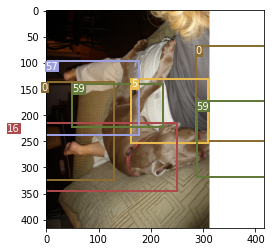

<Figure size 432x288 with 0 Axes>

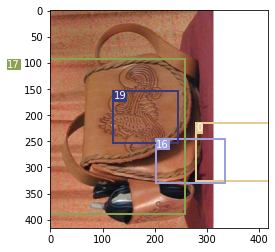

<Figure size 432x288 with 0 Axes>

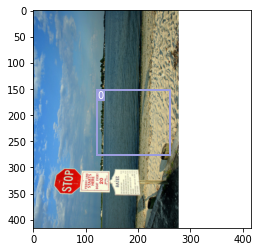

<Figure size 432x288 with 0 Axes>

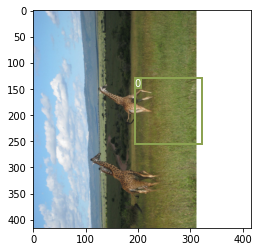

In [80]:
import matplotlib.pyplot as plt
import cv2
import random
import matplotlib.pyplot as plt
import colorsys
import random
import numpy as np
from matplotlib import patches


cmap = plt.get_cmap('tab20b')
colors = [cmap(i) for i in np.linspace(0, 1, 20)]
# classes = open(config["classes_names_path"], "r").read().split("\n")[:-1]

for idx, detections in enumerate(detections):
    plt.figure()
    fig, ax = plt.subplots(1)
    image = images.tensors[idx]
#     plt.imshow(restore_image(image,cfg))
    ax.imshow(restore_image(image,cfg))
    if detections is not None:
        print(idx, detections)
        unique_labels = detections[:, -1].cpu().unique()
        n_cls_preds = len(unique_labels)
        bbox_colors = random.sample(colors, n_cls_preds)
        for x1, y1, x2, y2, conf, cls_conf, cls_pred in detections:
            color = bbox_colors[int(np.where(unique_labels == int(cls_pred))[0])]
            # Rescale coordinates to original dimensions
#             ori_h, ori_w = images_origin[idx].shape[:2]
#             pre_h, pre_w = config["img_h"], config["img_w"]
            ori_h, ori_w = 416,416 #480, 640 is the original coco size
            pre_h, pre_w = 1,1 #416,416
            box_h = ((y2 - y1) / pre_h) * ori_h
            box_w = ((x2 - x1) / pre_w) * ori_w
            y1 = (y1 / pre_h) * ori_h
            x1 = (x1 / pre_w) * ori_w
            # Create a Rectangle patch
            bbox = patches.Rectangle((x1, y1), box_w, box_h, linewidth=2,
                                     edgecolor=color,
                                     facecolor='none')
            # Add the bbox to the plot
            
            ax.add_patch(bbox)
            
            
#             p = patches.Rectangle((x1, y1), x2 - x1, y2 - y1, linewidth=2,
#                               alpha=0.7, linestyle="dashed",
#                               edgecolor=color, facecolor='none')
#         ax.add_patch(p)
            # Add label
            plt.text(x1, y1, s=int(cls_pred), color='white',
                     verticalalignment='top',
                     bbox={'color': color, 'pad': 0})

In [ ]:
# outputs[0].shape
# output_cat = torch.cat([i.permute(0, 2, 3, 1).reshape(4, -1, 85) for i in outputs], dim=1)
# torch.sigmoid(output_cat[:, :, :4])
# torch.sigmoid(output_cat).shape
# output_list = torch.sigmoid(output_cat)
# output_list[1].shape
# output_list[:,:,4]

In [ ]:
for i in range(images.tensors.shape[0]):
    image = restore_image(images.tensors[i], cfg)
    plt.imshow(image)

In [17]:
def restore_image(image, 
                  cfg):
    image = image.to(torch.device("cpu"))
    image = (torch.transpose(image, 0, -1) + torch.tensor(cfg.INPUT.PIXEL_MEAN))
    image = np.flip(np.array(image), 2)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    return image

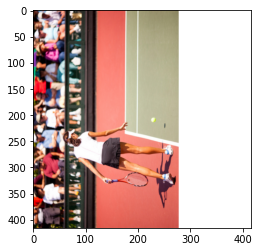

In [187]:
import cv2
image = restore_image(images.tensors[3], cfg)
# plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
plt.imshow(image)
plt.show()

In [192]:
def build_image(image,
                boxes=None,
                scores=None,
                class_ids=None, 
                class_names=None,
                threshold=0,
                figsize=(10, 10), 
                title=""):
    # get original image
    image = image.cpu()
    image = image.numpy()
    
    fig, ax = plt.subplots(1, figsize=figsize)
    # Show area outside image boundaries.
    height, width = image.shape[:2]
    ax.set_ylim(height + 10, -10)
    ax.set_xlim(-10, width + 10)
    ax.axis('off')
    ax.set_title(title)
    if boxes!=None:
        ax = add_boxes(boxes, ax, scores, class_ids, class_names, threshold)
    plt.imshow(image.astype(np.uint8))
    fig.tight_layout(pad = 0.0)
    fig.canvas.draw()
    plt.close(fig)
    data = np.fromstring(fig.canvas.tostring_rgb(), dtype=np.uint8, sep='')
    data = data.reshape(fig.canvas.get_width_height()[::-1] + (3,))
    return data


In [119]:
import matplotlib.pyplot as plt
import colorsys
import random
import numpy as np
from matplotlib import patches

def random_colors(N, bright=True):
    '''
    Generate random colors.
    To get visually distinct colors, generate them in HSV space then
    convert to RGB.
    '''
    brightness = 1.0 if bright else 0.7
    hsv = [(i / N, 1, brightness) for i in range(N)]
    colors = list(map(lambda c: colorsys.hsv_to_rgb(*c), hsv))
    random.shuffle(colors)
    return colors

def add_boxes(boxes, 
              ax, 
              scores=None,
              class_ids=None, 
              class_names=None,
              threshold=0):
    if threshold>0:
        assert scores!=None
        N = tf.where(scores>threshold).shape[0]
    else:
        N = boxes.shape[0]
    if not N:
        print("\n*** No instances to display *** \n")
        return ax
    colors = random_colors(N)
    for i in range(N):
        color = colors[i]

        # Bounding box
        if not np.any(boxes[i]):
            # Skip this instance. Has no bbox. Likely lost in image cropping.
            continue
        y1, x1, y2, x2 = boxes[i]
        y1, x1, y2, x2 = int(y1), int(x1), int(y2), int(x2)
        p = patches.Rectangle((x1, y1), x2 - x1, y2 - y1, linewidth=2,
                              alpha=0.7, linestyle="dashed",
                              edgecolor=color, facecolor='none')
        ax.add_patch(p)
        # Label
        if scores!=None:
            class_id = int(class_ids[i])
            score = scores[i] if scores is not None else None
            label = class_names[class_id] if class_names is not None else class_id
            x = random.randint(x1, (x1 + x2) // 2)
            caption = "{} {:.3f}".format(label, score) if score else label
            ax.text(x1, y1 + 8, caption, size=15,
                    color=color, backgroundcolor="none")
    return ax

def evaluate(images, model):
    model.eval()
    results_dict = {}
    images = images.to(device)
    cpu_device = torch.device("cpu")
    with torch.no_grad():
        output = model(images)
        output = [o.to(cpu_device) for o in output]
    model.train()
    return output



